In [1]:
import matplotlib.pyplot as plt
import numpy as np

## Load data

<AxesSubplot:xlabel='phi', ylabel='psi'>

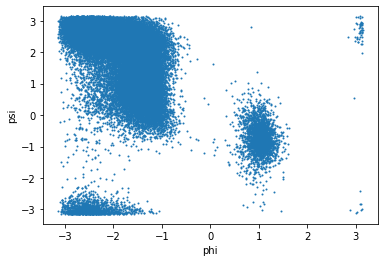

In [2]:
from stateinterpreter import load_dataframe

colvar = load_dataframe('alanine/COLVAR_DeepTICA')

colvar.plot.scatter('phi','psi',s=1)

## Compute descriptors

In [3]:
from stateinterpreter import load_trajectory
from stateinterpreter.descriptors import compute_descriptors

traj_dict = {
        'trajectory' : 'alanine/alanine.xtc',
        'topology' : 'alanine/input.ala2.pdb'
    }

traj = load_trajectory(traj_dict)
descriptors, feats_info = compute_descriptors( traj, descriptors = ['hbonds_contacts','dihedrals'] )

descriptors

Computing Hydrogen bonds contacts
Donors: [6, 16]
Acceptors: [ 5  6 15 16]
Descriptors: (50001, 10)


,HB_C ACE1-O -- ALA2-N,HB_C ACE1-O -- NME3-N,HB_C ALA2-N -- NME3-N,HB_C ALA2-O -- NME3-N,phi ACE1,sin_phi ACE1,cos_phi ACE1,psi ALA2,sin_psi ALA2,cos_psi ALA2
0,0.929044,0.100502,0.459074,0.930207,-2.368267,-0.698519,-0.715592,2.643943,0.477362,-0.878707
1,0.933527,0.260737,0.487284,0.934357,-1.818813,-0.969401,-0.245482,2.266428,0.767649,-0.640871
2,0.938087,0.183339,0.458683,0.942874,-1.962519,-0.924253,-0.381781,2.518990,0.583152,-0.812363
3,0.923064,0.237140,0.409412,0.943660,-1.546074,-0.999694,0.024719,2.609307,0.507504,-0.861649
4,0.941426,0.719332,0.687630,0.937150,-1.434391,-0.990711,0.135983,1.046329,0.865591,0.500752
...,...,...,...,...,...,...,...,...,...,...
49996,0.926837,0.085131,0.377203,0.933967,-2.707132,-0.420922,-0.907097,3.098981,0.042599,-0.999092
49997,0.927286,0.100841,0.408674,0.926865,-2.740673,-0.390265,-0.920702,-3.082756,-0.058803,-0.998270
49998,0.931873,0.205738,0.426683,0.930809,-1.793389,-0.975328,-0.220759,2.420310,0.660348,-0.750959
49999,0.928926,0.130366,0.427677,0.934629,-2.258257,-0.772860,-0.634577,2.640437,0.480439,-0.877028


## Hierarchical classification

/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/hierarchical.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  logweight = logweights[[parent_mask]]
/home/lbonati@iit.local/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:466: RuntimeWarning: some failed to converge after 50 iterations
  warnings.warn(msg, RuntimeWarning)


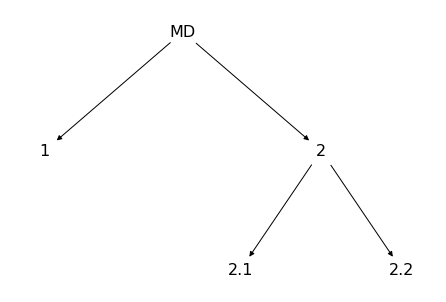

In [4]:
from stateinterpreter.utils.hierarchical import state_tree,hierarchy_pos,generate_state_labels_from_tree
import networkx as nx

cvs = colvar[['DeepTICA 1','DeepTICA 2']].values
bandwidth = 0.05

#weights
kbt = 2.5
logweights = colvar['opes.bias'].values/kbt

# build tree of metastable states
T = state_tree(cvs, bandwidth, logweights=logweights)

# draw tree
pos = hierarchy_pos(T)
options = {
    "with_labels": True,
    "font_size": 16,
    "node_size": 1000,
    "node_color": "white",
    "edgecolors": "white",
    "linewidths": 1,
    "width": 1,
}

nx.draw(T, pos, **options)

In [5]:
# generate state_labels for classification (one dataframe for each branch)
labels_list = generate_state_labels_from_tree(T, root='MD', fes_threshold=1 ) 

# get DeepTICA names
cv_list = []
for states_labels in labels_list:
    states_subset = states_labels['labels'].unique()
    states_subset = states_subset[states_subset != 'undefined' ]

    cv_level = states_subset[0].count('.')+1
    cv_list.append( [f'DeepTICA {cv_level}'] )

# example of labels 
print(cv_list[0])
labels_list[0]

['DeepTICA 1']


,labels,selection
0,2,True
1,2,True
2,2,True
3,2,True
4,2,True
...,...,...
49996,2,True
49997,2,True
49998,2,True
49999,2,True


In [6]:
# ANGLES
feat_type = 'angles'
select_feat = 'sin_|cos_'

desc = descriptors.filter(regex=select_feat)
print('Descriptors:',desc.shape)
desc.head()

Descriptors: (50001, 4)


,sin_phi ACE1,cos_phi ACE1,sin_psi ALA2,cos_psi ALA2
0,-0.698519,-0.715592,0.477362,-0.878707
1,-0.969401,-0.245482,0.767649,-0.640871
2,-0.924253,-0.381781,0.583152,-0.812363
3,-0.999694,0.024719,0.507504,-0.861649
4,-0.990711,0.135983,0.865591,0.500752


['DeepTICA 1']


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 1118.16it/s]

log_10 (lambda) : -0.84
Accuracy        : 100.0 %
No. features    : 1
Accuracy: 100%
State 2:
 sin_phi ACE1


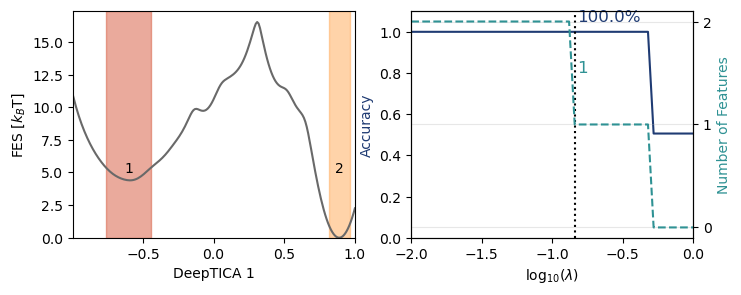

['DeepTICA 2']


Optimizing Lasso Estimator: 100%|██████████| 51/51 [00:00<00:00, 1029.41it/s]

log_10 (lambda) : -0.64
Accuracy        : 100.0 %
No. features    : 1
Accuracy: 99%
State 2.2:
 cos_psi ALA2



/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:398: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Min = cv[mask].min().values[0]
/home/lbonati@iit.local/work/md-stateinterpreter/stateinterpreter/utils/plot.py:399: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Max = cv[mask].max().values[0]
posx and posy should be finite values
posx and posy should be finite values


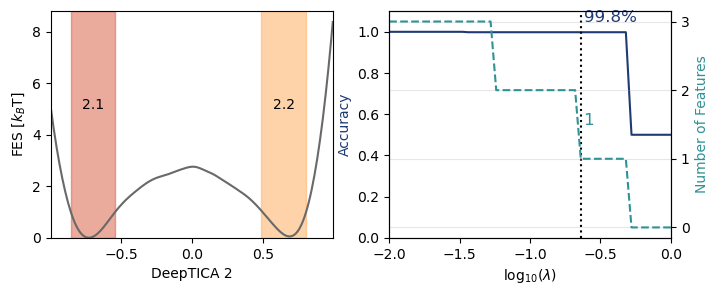

In [23]:
from stateinterpreter import prepare_training_dataset,Classifier
from stateinterpreter.utils.plot import plot_classifier_complexity_vs_accuracy,plot_histogram_features,paletteFessa,plot_fes
from stateinterpreter.utils.metrics import get_best_reg
from itertools import cycle
import matplotlib

# state labels TODO COmment
for cvs, states_labels in zip(cv_list,labels_list):
    print(cvs)

    # initialize classifier
    regularizers = np.geomspace(0.01, 1, 51)
    num_samples = 1000 # per metastable state

    sample_obj, features_names = prepare_training_dataset(descriptors=desc, states_labels = states_labels, n_configs= num_samples) 
    classifier = Classifier(sample_obj, features_names)
    classifier.compute(regularizers, max_iter= 10000)

    # get best reg
    reg,acc,num = get_best_reg(classifier)
    print(f'log_10 (lambda) : {np.round(np.log10(reg),3)}')
    print(f'Accuracy        : {np.round(acc*100,0)} %')
    print(f'No. features    : {num}')

    # count states
    num_states = len(classifier.classes)
    num_histo = num_states if num_states>2 else 1

    # classes names
    relevant_feat = classifier.feature_summary(reg)
    classes_names = classifier.classes

    # plot
    fig, (ax,ax2) = plt.subplots(1,2,figsize=(8,3),dpi=100)

    # COLOR 
    colors = cycle(iter(paletteFessa[::-1]))
    color = [next(colors) for i in range(5)]

    # PLOT FES
    cv_plot = colvar [states_labels['labels'] != 'undefined']
    logw_plot=None
    if logweights is not None:
        logw_plot = logweights[states_labels['labels'] != 'undefined']
    plot_fes(cv_plot[cvs],bandwidth,states_labels,logweights=logw_plot,num_samples=200,ax=ax,colors=color)

    # plot classfier
    ax = ax2
    _, ax_twin = plot_classifier_complexity_vs_accuracy(classifier, ax = ax)
    ax.axvline(np.log10(reg),linestyle='dotted',color='k')
    ax.text(np.log10(reg)+0.02,acc+.05,f'{np.round(acc*100,1)}%',fontsize=12,color='fessa0')
    ax_twin.text(np.log10(reg)+0.02,num+0.5,f'{num}',fontsize=12,color='fessa1')

    #print features
    classifier.print_selected(reg)
    plt.show()